# Building Query Pattern Classifiers for RAG Systems

# TODO: Add Artifact vs DOther
# TODO: Add another label -> multi-label -> add cloud deployments/BYOI + DATA Import/Export
# What should we invest in? -> Do people care about deployments/better artifacts etc
# TODO: Make another streamlit app where we just validate the label from the llm and then we just accept/reject label + 123 for Other labels

> Pre-requisites: Make sure you've completed the "1. Cluster Conversations" and "2. Better Summaries" notebooks to understand the underlying data and topic modeling results. You'll need the instructor and instructor_classify libraries installed, along with the labeled dataset we created from our clustering analysis.

## Why This Matters

In this notebook, we'll look at how we can act on these categories that we've discovered using topic modelling. We'll do so by deploying classifiers which will explicitly categorise user categories in real time.

By doing so, we'll be able to 

1. Detect Production Drift : Identify when certain query types increase in volume
2. Route queries appropriately : We can direct questions to specialised retrieval pipelines or tools based on their category

More importantly, by identifying and tracking query volumes, we can systematically prioritise areas for improvement. 

If we identify categories of queries which have high user satisfaction with low volume or queries which have low user satisfaction with high volume, these are immediate areas fof concern and prioritisation. 

## What You'll Learn

In this notebook, you'll discover how to:

1. Generate Weak Labels with Instructor-Classify
- Create an initial classifier using the instructor-classify framework
- Generate preliminary labels for your conversation dataset
- Prepare data for human verification


2. Create a Golden Label Dataset with the Annotation Tool
- Use app.py to review and correct weak labels
- Determine if classifier predictions are accurate
- Build a high-quality labeled dataset for evaluation


3. Iteratively Improve Classification Accuracy
- Start with a simple baseline classifier
- Enhance performance with few-shot examples and system prompts
- Measure improvements using confusion matrices and accuracy metrics

## Defining Our Classifier

Our topic modeling revealed several distinct clusters of user queries, with three major topics accounting for the majority of questions:

1. Users seeking help with experiment tracking and metrics logging
2. Users trying to manage artifacts and data versioning
3. Users needing assistance with integrations and deployment

In this notebook, we'll show how we might build a classifier which can identify queries related to creating, managing and versioning weights and biases artifacts. Let's define this using a binary classifier using `instructor-classify`

In [34]:
from instructor_classify.schema import LabelDefinition, ClassificationDefinition

artifact_label = LabelDefinition(
    label="artifact",
    description="This is a user query and document pair which is about creating, versioning and managing weights and biases artifacts.",
)

integrations_label = LabelDefinition(
    label="integrations",
    description="this is a user query and document pair which is concerned with how we can integrate weights and biases with specific libraries"
)

visualisation_label = LabelDefinition(
    label="visualisation",
    description="This is a user query and document pair which is concerned about how we can visualise the data that we've logged with weights and biases"
)

other_label = LabelDefinition(
    label="other",
    description="Use this label for other query types which don't belong to any of the other defined categories that you have been provided with",
)


classification_def = ClassificationDefinition(
    system_message="You're an expert at classifying a user and document pair. Look closely at the user query and determine what the query is about and how the document helps answer it. Then classify it according to the label(s) above. Classify irrelevant ones as Other",
    label_definitions=[artifact_label, other_label, visualisation_label, integrations_label],
)


This structure makes it easy to define multiple categories in a way that's clear to both humans and LLMs. It provides explicit definitions of what each category means, making it easier for the model to make accurate predictions.

Later in this notebook, we'll see how we can export this to a yaml format for easy versioning with `git`

### A Simple Example

Let's now see how `instructor-classify` works under the hood. We'll do so by passing in 4 sample queries and seeing how our classifier is able to deal with these test cases

In [37]:
import instructor
from instructor_classify.classify import Classifier
from openai import OpenAI

client = instructor.from_openai(OpenAI())
classifier = (
    Classifier(classification_def).with_client(client).with_model("gpt-4.1")
)

# Make a prediction
result = classifier.predict_multi("How do I version a weights and biases artifact?")
print(f"Classification: {result}")  # Should output "artifact";

result_2 = classifier.predict_multi("What is the square root of 9?")
print(f"Classification: {result_2}")  # Should output "not_artifact"

Classification: labels=['artifact']
Classification: labels=['other']


`instructor-classify` exposes a `batch_predict` function which parallelises this operation for us so that we can run evaluations efficiently over large datasets. Let's see it in action below with some test cases


In [39]:
tests = [
    "How do I version a weights and biases artifact?",
    "What is the square root of 9?",
    "How do I integrate weights and biases with pytorch?",
    "How do I deploy weights and biases in my own infrastructure?",
    "How can I log my model training runs using artifacts and then visualise it?",
]

labels = [
    ["artifact"],
    ["other"],
    ["integrations"],
    ["other"],
    ["artifact","visualisations"],
]

results = classifier.batch_predict_multi(tests)
for query, result, label in zip(tests, results, labels):
    print(f"Query: {query}\nClassification: {result}\nExpected: {label}\n")


Query: How do I version a weights and biases artifact?
Classification: labels=['artifact']
Expected: ['artifact']

Query: What is the square root of 9?
Classification: labels=['other']
Expected: ['other']

Query: How do I integrate weights and biases with pytorch?
Classification: labels=['integrations']
Expected: ['integrations']

Query: How do I deploy weights and biases in my own infrastructure?
Classification: labels=['other']
Expected: ['other']

Query: How can I log my model training runs using artifacts and then visualise it?
Classification: labels=['artifact', 'visualisation']
Expected: ['artifact', 'visualisations']



Our classifier performs pretty badly here, it only gets the right label 20% of the time. In the other cases, it simply just returns all of the labels.

Let's now use our classifier to generate some weak labels. We'll then have a simple UI where we can either approve or reject these labels.

We'll then filter through the rejected labels and manually label them ourselves thereafter in a separate step. By doing so, we can generate much more labels quickly.

In [44]:
import json

with open("./data/conversations.json") as f:
    data = json.loads(f.read())

texts = [
    {
        "query": item["query"],
        "matching_document": item["matching_document"],
        "query_id": item["query_id"],
    }
    for item in data
]

results = classifier.batch_predict_multi(texts[:110]) 

In [45]:
with open("./data/generated.jsonl","w+") as f:
    for item,result in zip(data,results):
        f.write(json.dumps({
            "query": item["query"],
            "matching_document": item["matching_document"],
            "query_id": item["query_id"],
            "labels": result.labels
        })+"\n")

## Evaluating Our Classifier

We've labelled a dataset of ~100 items our of our 560 conversations ahead of time. If you'd like to label more datasets, we've provided an `app.py` file which you can run using the command `streamlit run app.py`.

We'll be splitting this into a test and validation split. We'll be using the `validation` split to iterate on our prompt and experiment with different few shot examples before using the `test` split to validate our classifier's performance. 

We'll be using a 70-30 split with 70% of our data used for validation and 30% used for testing our final classifier. 

In [46]:
import json
import random

with open("./data/labels.jsonl") as f:
    data = [json.loads(line) for line in f]

# Set random seed for reproducibility
random.seed(42)

# Shuffle the data
random.shuffle(data)

# Calculate split index
split_idx = int(len(data) * 0.7)

# Split into validation and test sets
val_set = data[:split_idx]
test_set = data[split_idx:]

print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")


Validation set size: 77
Test set size: 33


### Determining a baseline

Let's now calculate a baseline and see how well our initial classification model performs.

In [47]:
val_text = [
    f"Query: {item['query']}\n Retrieved Document: {item['matching_document']}"
    for item in val_set
]
val_labels = [item["labels"] for item in val_set]

test_text = [
    f"Query: {item['query']}\n Retrieved Document: {item['matching_document']}"
    for item in test_set
]
test_labels = [item["labels"] for item in test_set]

Let's now define a function which runs the classifier on the validation set and the test set to see our initial starting point. We'll look at some of the failure cases and then iterately improve our classifier.

In [51]:
from sklearn.metrics import confusion_matrix
from instructor_classify.classify import Classifier

def predict_and_evaluate(classifier: Classifier, texts: list[str], labels:list[list[str]]):
    predictions = classifier.batch_predict_multi(texts)
    pred_labels = [p.labels for p in predictions]
    
    return {
        "accuracy": sum(set(p) == set(l) for p, l in zip(pred_labels, labels)) / len(predictions),
        "queries": texts,
        "labels": labels, 
        "predictions": pred_labels
    }

classifier = (
    Classifier(classification_def).with_client(client).with_model("gpt-4.1")
)
predictions = predict_and_evaluate(classifier, val_text, val_labels)
predictions["accuracy"]

0.11688311688311688

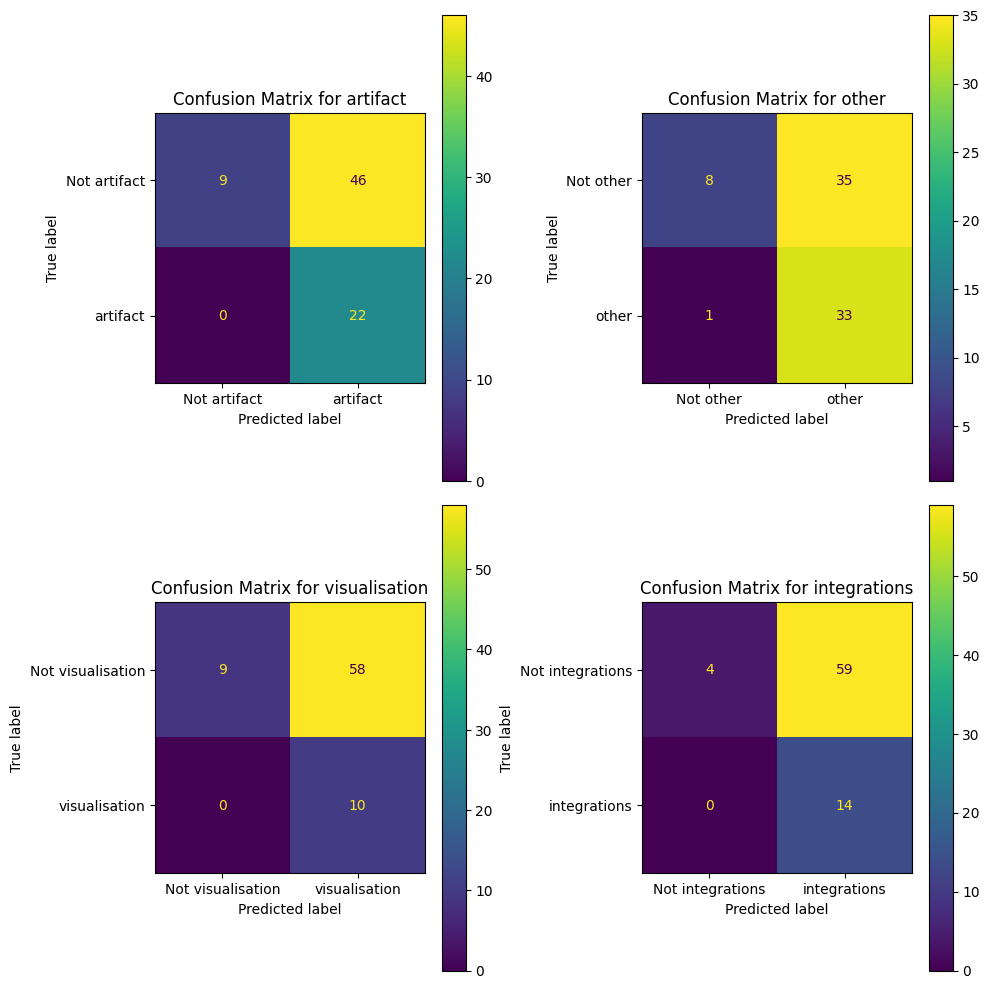

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Get unique labels from all possible labels
unique_labels = ["artifact", "other", "visualisation", "integrations"]

# Convert predictions and true labels to binary matrix format
y_true = np.array([[1 if label in true_set else 0 for label in unique_labels] 
                   for true_set in predictions["labels"]])
y_pred = np.array([[1 if label in pred_set else 0 for label in unique_labels]
                   for pred_set in predictions["predictions"]])

# Calculate confusion matrix for each label
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

# Plot confusion matrix for each label
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, (matrix, label) in enumerate(zip(conf_matrices, unique_labels)):
    ax = axes[i//2, i%2]
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[f"Not {label}", label])
    disp.plot(ax=ax)
    ax.set_title(f'Confusion Matrix for {label}')

plt.tight_layout()
plt.show()

Let's now see how it looks like when we run it on our test set

In [54]:
test_predictions = predict_and_evaluate(classifier,test_text, test_labels)
test_predictions["accuracy"]

0.09090909090909091

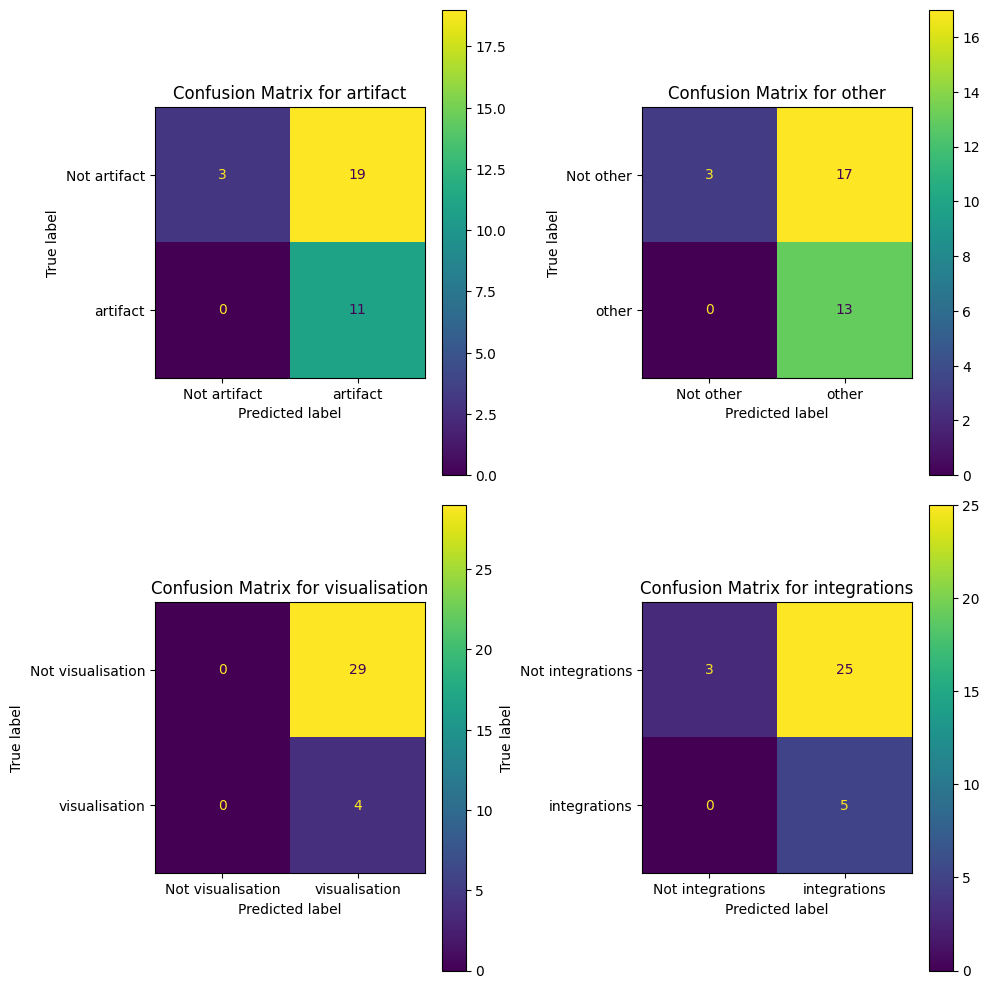

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Get unique labels from all possible labels
unique_labels = ["artifact", "other", "visualisation", "integrations"]

# Convert predictions and true labels to binary matrix format
y_true = np.array([[1 if label in true_set else 0 for label in unique_labels] 
                   for true_set in test_predictions["labels"]])
y_pred = np.array([[1 if label in pred_set else 0 for label in unique_labels]
                   for pred_set in test_predictions["predictions"]])

# Calculate confusion matrix for each label
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

# Plot confusion matrix for each label
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, (matrix, label) in enumerate(zip(conf_matrices, unique_labels)):
    ax = axes[i//2, i%2]
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[f"Not {label}", label])
    disp.plot(ax=ax)
    ax.set_title(f'Confusion Matrix for {label}')

plt.tight_layout()
plt.show()

Having an initial dataset to measure our LLM classifier performance was essential for identifying critical prompt engineering issues before deployment and establishing a baseline for improvement. Without this evaluation, we would have been unaware of how poorly our current prompts are guiding the model's classification decisions, potentially leading to unreliable outputs in production.

This initial evaluation reveals that our LLM classifier suffers from severe positive prediction bias across all categories, with accuracy ranging from 12.1% for visualization detection to 60.6% for "other" classification. Let's take a look at the 

### Looking at Edge Cases

Let's now look at the cases where our model performed badly. We can see from our confusion matrix above that our classifier tends to classify non-artifact related queries as artifact queries. 

Let's look through some of the failed cases manually where this happens from our validation set to see if we might be ale to understand why this is happening.

In [71]:
len(predictions["labels"]), len(predictions["labels"])

(77, 77)

In [76]:
labels = [label.label for label in classifier.definition.label_definitions]

for classification_label_option in labels:
    count = 3
    print(f"Examining Failure Cases for {classification_label_option}")
    for query,prediction,label in zip(predictions['queries'],predictions["predictions"],predictions["labels"]):
        if classification_label_option in label and set(label) != set(prediction):
            print(f"""
=====

Prediction: {prediction}            
Label: {label}

Query: 
{query}

======
""")
            count-=1
        
        if count == 0:
            break
    print("========\n\n\n\n")
    
    break


Examining Failure Cases for artifact

=====

Prediction: ['artifact', 'other', 'visualisation', 'integrations']            
Label: ['artifact']

Query: 
Query: Steps to link a run to the model registry in Weights & Biases.
 Retrieved Document: ## W&B Tutorial with Pytorch Lightning
### Model Registry

After logging a bunch of checkpoints across multiple runs during experimentation, now comes time to hand-off the best checkpoint to the next stage of the workflow (e.g. testing, deployment).  

The model registry offers a centralized place to house the best checkpoints for all your model tasks. Any `model` artifact you log can be "linked" to a Registered Model. Here are the steps to start using the model registry for more organized model management:
1. Access your team's model registry by going the team page and selecting `Model Registry`  

1. Create a new Registered Model.
2. Go to the artifacts tab of the project that holds all your model checkpoints
3. Click "Link to Registry" for the

We can see here that there are a few queries here that are tripping up our classifier

1. `What are the key features of wandb` : This includes some information about Artifacts in the retrieved document but the user's query itself is not explicitly about the usage of Artifacts with Weights and Biases.

2. `Weights & Biases integration OpenAI` : This is a question about integrations, specifically about the OpenAI integration with WandDB and the user's query is not related to the storage, usage or management of artifacts at all

Let's see how we can improve on `instructor-classify` by leveraging few shot examples and a better system prompt

In [83]:
import instructor
from instructor_classify.classify import Classifier
from instructor_classify.schema import LabelDefinition, ClassificationDefinition
from openai import OpenAI

client = instructor.from_openai(OpenAI())

artifact_label = LabelDefinition(
    label="artifact",
    description="This is a user query and document pair which is about creating, versioning and managing weights and biases artifacts.",
)

integrations_label = LabelDefinition(
    label="integrations",
    description="this is a user query and document pair which is concerned with how we can integrate weights and biases with specific libraries"
)

visualisation_label = LabelDefinition(
    label="visualisation",
    description="This is a user query and document pair which is concerned about how we can visualise the data that we've logged with weights and biases"
)

other_label = LabelDefinition(
    label="other",
    description="Use this label for other query types which don't belong to any of the other defined categories that you have been provided with",
)


classification_def = ClassificationDefinition(
    system_message="""You're an expert at classifying Weights & Biases user queries and documentation pairs. Carefully analyze the user's query to determine if it falls into one of these categories: 1) Artifacts - questions about creating, versioning and managing W&B artifacts, 2) Integrations - questions about integrating W&B with specific libraries/tools, 3) Visualization - questions about visualizing logged data in W&B, or 4) Other - queries that don't fit the above categories. Focus primarily on the user's intent in their query. When analyzing the documentation, only consider the parts that are relevant to answering the user's specific question. Even if the documentation mentions multiple topics, classify based solely on what the user is explicitly asking about.""",
    label_definitions=[artifact_label, other_label, visualisation_label, integrations_label],
)


classifier = (
    Classifier(classification_def).with_client(client).with_model("gpt-4.1")
)

classifier.predict_multi(
    text="""
<user query>
    Steps to link a run to the model registry in Weights & Biases.
</user query>

<context>
 Retrieved Document: ## W&B Tutorial with Pytorch Lightning
### Model Registry

After logging a bunch of checkpoints across multiple runs during experimentation, now comes time to hand-off the best checkpoint to the next stage of the workflow (e.g. testing, deployment).  

The model registry offers a centralized place to house the best checkpoints for all your model tasks. Any `model` artifact you log can be "linked" to a Registered Model. Here are the steps to start using the model registry for more organized model management:
1. Access your team's model registry by going the team page and selecting `Model Registry`  

1. Create a new Registered Model.
2. Go to the artifacts tab of the project that holds all your model checkpoints
3. Click "Link to Registry" for the model artifact version you want. (Alternatively you can link a model via api with `wandb.run.link_artifact`)
</context>
"""
)

MultiClassificationModel(labels=['artifact'])

## Improving Our Classifier

Now that we've identified these cases, we can do two main things to improve our classifier. 

The first thing is to supply a better system prompt. Specifically we'll tell our model to look closely at the user query to determine if the user has an initial query about manging and versioning artifacts.

In [119]:
from instructor_classify.schema import LabelDefinition, ClassificationDefinition

artifact_label = LabelDefinition(
    label="artifact",
    description="This is a user query and document pair which has a user query that is about creating, versioning and managing weights and biases artifacts.",
)

not_artefact_label = LabelDefinition(
    label="not_artifact",
    description="This is a user query and document pair which does not have a user query that is about creating, versioning and managing weights and biases artifacts.",
)

classification_def = ClassificationDefinition(
    system_message="""
You're an expert at classifying user queries and documents as related to creating, versioning and managing weights and biases artifacts.

You'll be given a user query and a retrieved matching document. Your job is to classify the user query as either an artifact query or not an artifact query.

Your job is to look closely at the user query and the retrieved document to determine if the user's query is about creating, versioning and managing weights and biases artifacts. This does not include queries about integrations with other libraries/providers unless the user is explicitly asking about how to manage the artifacts from these integrations.
""",
    label_definitions=[artifact_label, not_artefact_label],
)


In [120]:
client = instructor.from_openai(OpenAI())
classifier = (
    Classifier(classification_def).with_client(client).with_model("gpt-4.1-mini")
)

In [122]:
def predict_and_evaluate(classifier, texts, labels):
    predictions = classifier.batch_predict(texts)
    return {
        "accuracy": sum(pred.label == label for pred, label in zip(predictions, labels))
        / len(predictions),
        "confusion_matrix": confusion_matrix(
            labels, [p.label for p in predictions], labels=["artifact", "not_artifact"]
        ),
        "queries": texts,
        "labels": labels,
        "predictions": [p.label for p in predictions],
    }


predictions = predict_and_evaluate(classifier, val_text, val_labels)
predictions["accuracy"]

0.9506172839506173

Let's now see how our model performs by using a confusion matrix

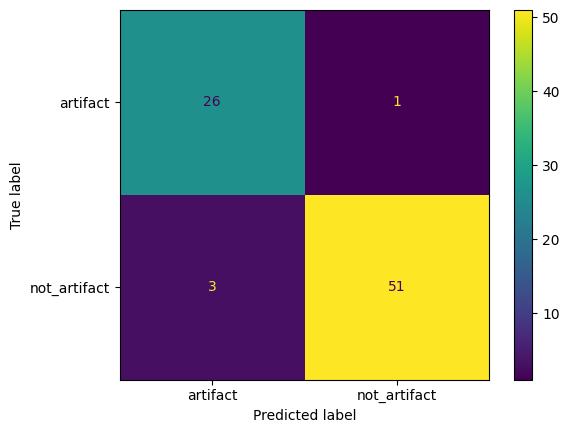

In [123]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(
    confusion_matrix=predictions["confusion_matrix"],
    display_labels=["artifact", "not_artifact"],
)
disp.plot()
plt.show()

Let's now examine our last 4 failure cases and see if we can get aroud this

In [124]:
count = 3
for query, label, pred in zip(
    predictions["queries"], predictions["labels"], predictions["predictions"]
):
    count -= 1
    if label != pred:
        print("=====")
        print(f"Label: {label}")
        print(f"Prediction: {pred}")
        print(f"{query}")
        print("=====")

    if count == 3:
        break

=====
Label: not_artifact
Prediction: artifact
Query: wandb.Table documentation
 Retrieved Document: ## Table

View source on GitHub  

The Table class used to display and analyze tabular data.  

```
Table(
columns=None, data=None, rows=None, dataframe=None, dtype=None, optional=(True),
allow\_mixed\_types=(False)
)

```  

Unlike traditional spreadsheets, Tables support numerous types of data:
scalar values, strings, numpy arrays, and most subclasses of `wandb.data_types.Media`.
This means you can embed `Images`, `Video`, `Audio`, and other sorts of rich, annotated media
directly in Tables, alongside other traditional scalar values.  

This class is the primary class used to generate the Table Visualizer
in the UI: <https://docs.wandb.ai/guides/data-vis/tables>.  

Tables can be constructed with initial data using the `data` or
`dataframe` parameters:
=====
=====
Label: not_artifact
Prediction: artifact
Query: Integrating Weights & Biases with Hugging Face's Accelerate
 Retrieved Doc

## Conclusion
In this series of notebooks, we've built a systematic workflow for improving RAG systems through query pattern analysis. Beginning with topic modeling, we identified key clusters around experiment tracking, artifact management, and integrations in Weights & Biases, giving us insight into what users are actually asking and where our system might be falling short.

We enhanced our approach by developing domain-specific summarization techniques that transformed generic descriptions into precise insights about W&B features and user intents. This led to more meaningful clusters that better reflected real user needs and created a foundation for targeted improvements.

Finally, we built a classifier to automatically categorize incoming queries, enabling ongoing monitoring and targeted interventions. This classification system now sets the stage for more advanced RAG components - specialized retrieval pipelines, metadata extraction, and function calling systems that address specific user needs effectively. By understanding query patterns systematically, we've created a data-driven foundation for continuous RAG improvement based on actual user behavior.